Dataset Shape: (1118669, 34)


,transaction_id,order_date,customer_id,product_id,product_name,category,subcategory,brand,original_price_inr,discount_percent,...,is_festival_sale,festival_name,customer_rating,return_status,order_month,order_year,order_quarter,product_weight_kg,is_prime_eligible,product_rating
0,TXN_2015_00000001,2015-01-25,CUST_2015_00003884,PROD_000021,Samsung Galaxy S6 16GB Black,Electronics,Smartphones,Samsung,123614.29,27.91,...,True,Republic Day Sale,5.0,Delivered,1,2015,1,0.19,True,4.7
1,TXN_2015_00000002,2015-05-01,CUST_2015_00011709,PROD_000055,OnePlus OnePlus 2 16GB White,Electronics,Smartphones,OnePlus,54731.86,0.00,...,False,NaN,4.5,Delivered,1,2015,1,0.20,True,4.1
2,TXN_2015_00000003,2015-01-24,CUST_2015_00004782,PROD_000039,Samsung Galaxy Note 5 64GB Black,Electronics,Smartphones,Samsung,97644.25,46.93,...,True,Republic Day Sale,NaN,Delivered,1,2015,1,0.17,True,3.3
3,TXN_2015_00000004,2015-01-28,CUST_2015_00008105,PROD_000085,Motorola Moto G (3rd Gen) 16GB Black,Electronics,Smartphones,Motorola,21947.26,0.00,...,False,NaN,3.0,Delivered,1,2015,1,0.22,True,3.5
4,TXN_2015_00000005,2015-01-31,CUST_2015_00002955,PROD_000055,OnePlus OnePlus 2 16GB White,Electronics,Smartphones,OnePlus,54731.86,0.00,...,False,NaN,4.0,Delivered,1,2015,1,0.20,True,4.1


----- PRODUCT LIFECYCLE & INVENTORY PATTERNS -----


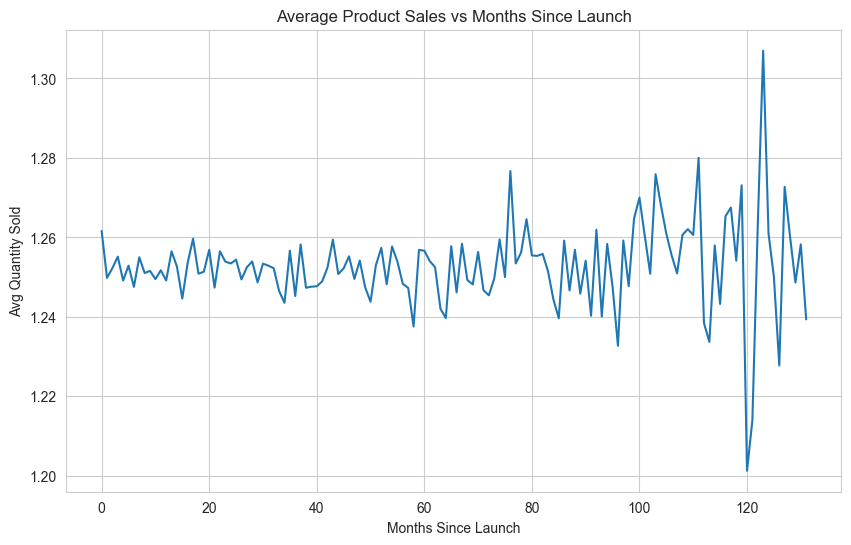

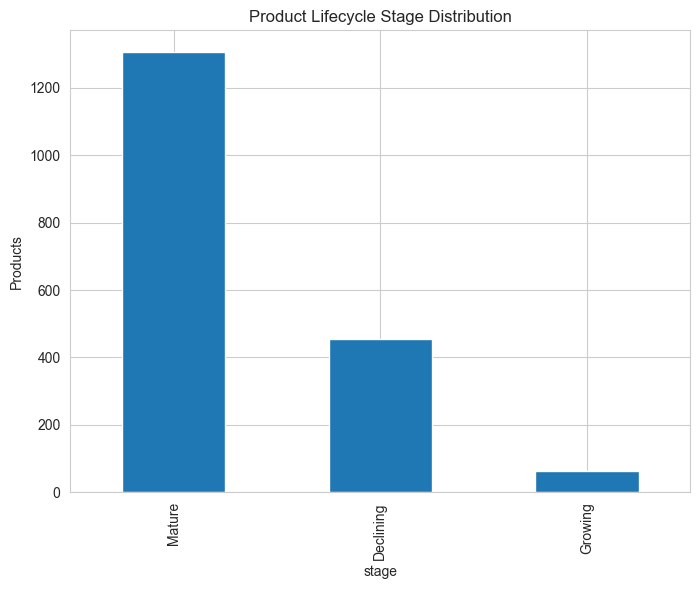

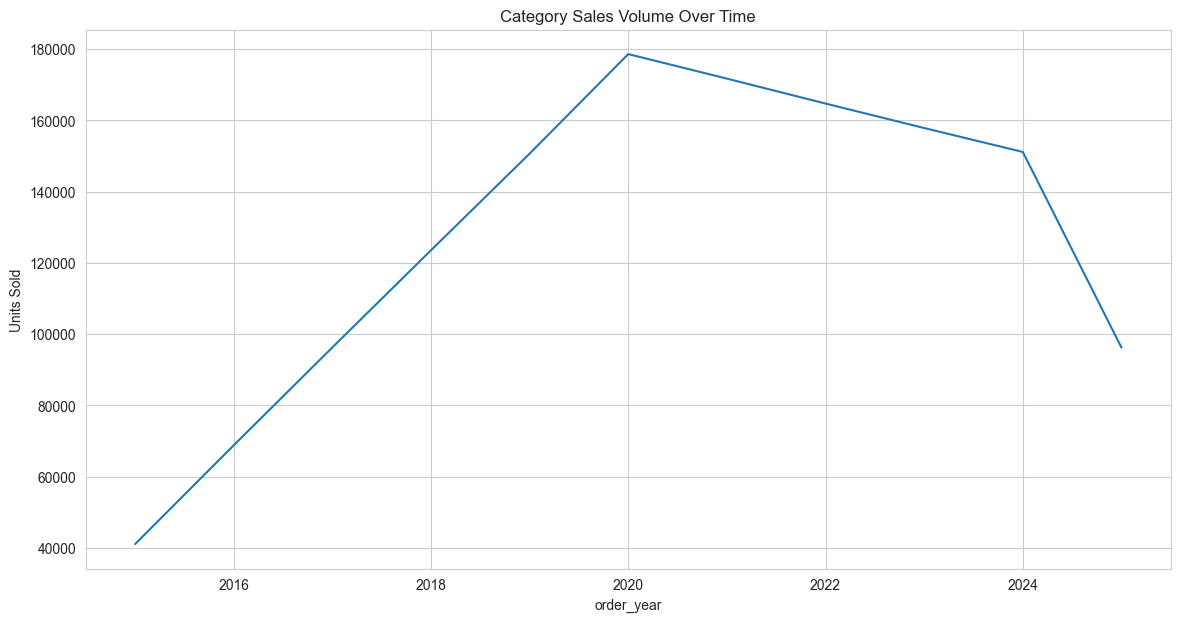

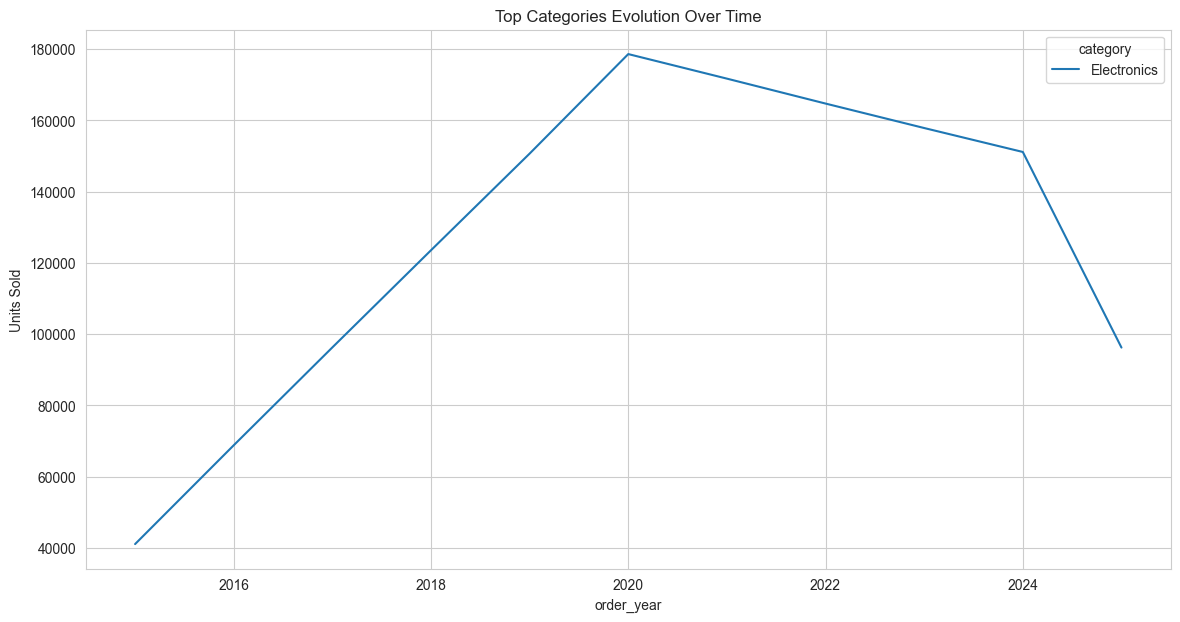

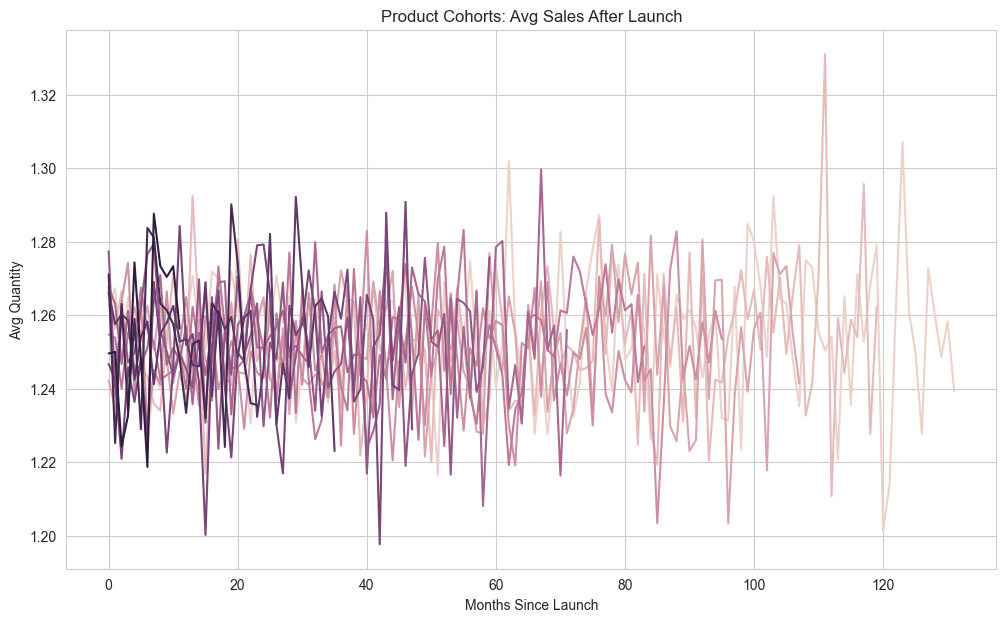

product_id
PROD_001935    41.000000
PROD_001733    40.714286
PROD_001691    40.285714
PROD_001943    40.285714
PROD_001710    40.142857
PROD_001899    39.285714
PROD_000055    39.285714
PROD_002001    38.571429
PROD_000162    38.142857
PROD_000077    38.000000
PROD_001600    37.571429
PROD_000003    37.428571
PROD_000028    36.714286
PROD_001692    36.428571
PROD_000163    34.857143
Name: quantity, dtype: float64

product_id
PROD_001991    1.142857
PROD_001226    1.250000
PROD_001367    1.285714
PROD_001956    1.428571
PROD_001230    1.428571
PROD_001327    1.500000
PROD_001244    1.571429
PROD_001225    1.600000
PROD_001220    1.600000
PROD_001316    1.625000
PROD_001222    1.666667
PROD_001248    1.666667
PROD_001246    1.666667
PROD_001083    1.687500
PROD_001326    1.714286
Name: quantity, dtype: float64

✅ EDA_13 COMPLETED SUCCESSFULLY


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

# ============================================================
# LOAD MASTER DATA
# ============================================================

df = pd.read_csv("../master/amazon_india_master_2015_2025.csv")

print("Dataset Shape:", df.shape)
display(df.head())

# ============================================================
# BASIC CLEAN
# ============================================================

df["order_date"] = pd.to_datetime(df["order_date"], errors="coerce")

num_cols = [
    "quantity",
    "final_amount_inr",
]

df[num_cols] = df[num_cols].apply(pd.to_numeric, errors="coerce")

df = df.dropna(
    subset=[
        "product_id",
        "order_date",
        "category",
        "quantity",
    ]
)

# Add Year-Month
df["year_month"] = df["order_date"].dt.to_period("M")

# ============================================================
# QUESTION 18 : PRODUCT LIFECYCLE ANALYSIS
# ============================================================

print("----- PRODUCT LIFECYCLE & INVENTORY PATTERNS -----")

# ------------------------------------------------------------
# PRODUCT LAUNCH DATE
# ------------------------------------------------------------

product_launch = (
    df.groupby("product_id")["order_date"]
      .min()
      .rename("launch_date")
)

df = df.merge(product_launch, on="product_id", how="left")

df["months_since_launch"] = (
    (df["order_date"].dt.to_period("M") -
     df["launch_date"].dt.to_period("M"))
    .apply(lambda x: x.n)
)

# ------------------------------------------------------------
# SALES TRAJECTORY BY MONTHS SINCE LAUNCH
# ------------------------------------------------------------

lifecycle_curve = (
    df.groupby("months_since_launch")["quantity"]
      .mean()
)

plt.figure(figsize=(10,6))
lifecycle_curve.plot()
plt.title("Average Product Sales vs Months Since Launch")
plt.xlabel("Months Since Launch")
plt.ylabel("Avg Quantity Sold")
plt.show()

# ------------------------------------------------------------
# CLASSIFY PRODUCTS BY LIFECYCLE STAGE
# ------------------------------------------------------------

product_life = (
    df.groupby(["product_id","months_since_launch"])["quantity"]
      .sum()
      .reset_index()
)

recent_growth = (
    product_life[product_life["months_since_launch"] <= 6]
    .groupby("product_id")["quantity"]
    .mean()
)

late_sales = (
    product_life[product_life["months_since_launch"] > 12]
    .groupby("product_id")["quantity"]
    .mean()
)

life_stage = pd.DataFrame({
    "early_avg": recent_growth,
    "late_avg": late_sales
}).dropna()

life_stage["stage"] = np.where(
    life_stage["late_avg"] > life_stage["early_avg"] * 1.2,
    "Growing",
    np.where(
        life_stage["late_avg"] < life_stage["early_avg"] * 0.6,
        "Declining",
        "Mature"
    )
)

stage_dist = life_stage["stage"].value_counts()

plt.figure(figsize=(8,6))
stage_dist.plot(kind="bar")
plt.title("Product Lifecycle Stage Distribution")
plt.ylabel("Products")
plt.show()

# ------------------------------------------------------------
# CATEGORY EVOLUTION OVER DECADE
# ------------------------------------------------------------

yearly_cat = (
    df.groupby(["order_year","category"])["quantity"]
      .sum()
      .reset_index()
)

plt.figure(figsize=(14,7))
sns.lineplot(
    data=yearly_cat,
    x="order_year",
    y="quantity",
    hue="category",
    legend=False
)
plt.title("Category Sales Volume Over Time")
plt.ylabel("Units Sold")
plt.show()

# ------------------------------------------------------------
# TOP 6 CATEGORIES TREND
# ------------------------------------------------------------

top_categories = (
    df.groupby("category")["quantity"]
      .sum()
      .sort_values(ascending=False)
      .head(6)
      .index
)

plt.figure(figsize=(14,7))
sns.lineplot(
    data=yearly_cat[yearly_cat["category"].isin(top_categories)],
    x="order_year",
    y="quantity",
    hue="category"
)
plt.title("Top Categories Evolution Over Time")
plt.ylabel("Units Sold")
plt.show()

# ------------------------------------------------------------
# PRODUCT COHORTS BY LAUNCH YEAR
# ------------------------------------------------------------

df["launch_year"] = df["launch_date"].dt.year

cohort_sales = (
    df.groupby(["launch_year","months_since_launch"])["quantity"]
      .mean()
      .reset_index()
)

plt.figure(figsize=(12,7))
sns.lineplot(
    data=cohort_sales,
    x="months_since_launch",
    y="quantity",
    hue="launch_year",
    legend=False
)
plt.title("Product Cohorts: Avg Sales After Launch")
plt.xlabel("Months Since Launch")
plt.ylabel("Avg Quantity")
plt.show()

# ------------------------------------------------------------
# FAST RISING PRODUCTS (FIRST 6 MONTHS)
# ------------------------------------------------------------

fast_risers = recent_growth.sort_values(ascending=False).head(15)

display(fast_risers)

# ------------------------------------------------------------
# FAST DECLINERS
# ------------------------------------------------------------

fast_decliners = late_sales.sort_values().head(15)

display(fast_decliners)

print("✅ EDA_13 COMPLETED SUCCESSFULLY")
